In [1]:
from biom import Table, load_table
from biom.util import biom_open
from unifrac import faith_pd
from skbio import TreeNode
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
from statsmodels.stats import multitest
import os
from sklearn.utils import resample
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

import multiprocessing
from multiprocessing import Pool
from itertools import repeat
N_WORKERS = multiprocessing.cpu_count()


In [2]:
def load_biom(data):
    table_path = data['table_biom_path']
    table_biom = load_table(table_path)
    return table_biom


def filter_max_frequency(table, threshold=1):
    maxes = table.max('observation')
    above_threshold = (maxes > threshold)
    ids_to_keep = table.ids('observation')[above_threshold]
    filtered_table = table.filter(ids_to_keep, inplace=False, axis='observation')
    return filtered_table


def calculate_faiths_pd(data):
    table_biom_path = data['table_biom_path']
    tree_path = data['tree_path']
    faith_series = pd.DataFrame(faith_pd(table_biom_path, tree_path))
    faith_series.index.name = '#SampleID'
    return faith_series

In [3]:
tree_path = 'data/wol/astral.cons.nid.e5p50.nwk'
wol_tree_path = 'data/wol/wol-tree.nwk'

In [4]:
wol_metadata = pd.read_csv('data/wol/wolMetadata.tsv', sep='\t', index_col=0)

In [5]:
dataset = 'finrisk'
target = 'BL_AGE'
finrisk_data = {
    'table_biom_path': f'data/{dataset}/anonymized-{dataset}-MG-{target}-filtered_rarefied_table.biom',
    'tree_path': wol_tree_path,
}
finrisk_metadata_path = 'data/finrisk/anonymized.age-only.finrisk.metadata.txt'


In [6]:
finrisk_16S_data = {
    'table_biom_path': f'data/{dataset}/anonymized-{dataset}-16S-{target}-filtered_rarefied_table.biom',
    'tree_path': 'data/finrisk/insertion_tree.relabelled.tre',
}

In [7]:
finrisk_faith_pd = calculate_faiths_pd(finrisk_data)
finrisk_metadata = pd.read_csv(finrisk_metadata_path, sep='\t').set_index('#SampleID')

In [8]:
finrisk_table = load_biom(finrisk_data)

In [9]:
finrisk_16S_table = load_biom(finrisk_16S_data)

In [10]:
finrisk_wol_ids = finrisk_table.ids('observation')
keep_ids = finrisk_wol_ids[wol_metadata.loc[finrisk_wol_ids]['superkingdom'] == 'Bacteria']

In [11]:
finrisk_table.filter(keep_ids, 'observation')

924 x 6424 <class 'biom.table.Table'> with 924847 nonzero entries (15% dense)

In [12]:
def calculate_observed_otus(data):
    table_biom = load_biom(data)
    observed_otus = pd.DataFrame(
        (table_biom.matrix_data > 0).sum(0).reshape(-1, 1),
        columns=['observed_otus'],
        index=pd.Series(
            table_biom.ids('sample'),
            name='#SampleID',
        ),
    )
    return observed_otus

In [13]:
observed_otus = calculate_observed_otus(finrisk_data)

In [14]:
all_finrisk = finrisk_faith_pd.join(finrisk_metadata).join(observed_otus)

In [15]:
faith_pd_16S = calculate_faiths_pd(finrisk_16S_data)
observed_otus_16S = calculate_observed_otus(finrisk_16S_data)

In [16]:
all_finrisk_16S = faith_pd_16S.join(observed_otus_16S).join(finrisk_metadata)
all_finrisk_16S = all_finrisk_16S.loc[all_finrisk.index]

In [17]:
datasets = {
    '16S': all_finrisk_16S,
    'shotgun': all_finrisk,
}

In [18]:
def is_old(x):
    return x >= 60
def is_young(x):
    return x <= 35

In [19]:
# check out this source on the bootstrap
# https://wormlabcaltech.github.io/mprsq/stats_tutorial/nonparametric_bootstrapping.html
# (the code below is liberally copy pasted)

In [20]:
def non_parametric_bootstrap(x, f, nsim=10000, **kwargs):
    """
    
    Params:
    x, y - data (numpy arrays)
    f - test function to calculate
    nsim - number of simulations to run
    """
    statistic = np.zeros(nsim)
    for i in range(nsim):
        # simulate x
        indices = np.random.randint(0, len(x), len(x))
        X = x[indices]
        X += np.random.normal(0, 0.05, len(x))
        
        statistic[i] = f(X, **kwargs)
    
    return statistic

In [21]:
def print_mean_and_confidence_intervals(btstrp):
    btstrp = np.sort(btstrp)
    mean = btstrp.mean()
    message = "Mean = {0:.2g}; CI = [{1:.2g}, {2:.2g}]"
    five = int(np.floor(0.05*len(btstrp)))
    ninetyfive = int(np.floor(0.95*len(btstrp)))
    print(message.format(mean, btstrp[five], btstrp[ninetyfive]))

def difference_of_means(x, y):
    """Calculate the difference in the means of two datasets x and y. Returns a scalar equal to mean(y) - mean(x)"""
    return np.mean(y) - np.mean(x)

def test_null(x, y, statistic, iters=1000):
    """
    Given two datasets, test a null hypothesis using a permutation test for a given statistic.
    
    Params:
    x, y -- ndarrays, the data
    statistic -- a function of x and y
    iters -- number of times to bootstrap
    
    Ouput:
    a numpy array containing the bootstrapped statistic
    """
    def permute(x, y):
        """Given two datasets, return randomly shuffled versions of them"""
        # concatenate the data
        new = np.concatenate([x, y])
        # shuffle the data
        np.random.shuffle(new)
        # return the permuted data sets:
        return new[:len(x)], new[len(x):]

    # do the bootstrap
    return np.array([statistic(*permute(x, y)) for _ in range(iters)])

In [22]:
def power_estimate(dataset, subsample_size, n_power_iter=100, n_hypothesis_iter=10**5, alpha=0.05, map_=map):
    alpha_metric = 'faith_pd'
    
    def f(x):
        dataset, subsample_size, alpha_metric, n_hypothesis_iter = x
        subsampled_dataset = dataset.sample(subsample_size)
        old_df = subsampled_dataset[subsampled_dataset.AgeCategory == 'Old']
        young_df = subsampled_dataset[subsampled_dataset.AgeCategory == 'Young']
        old_alpha = old_df[alpha_metric]
        young_alpha = young_df[alpha_metric]
        diff = test_null(old_alpha, young_alpha, difference_of_means, iters=n_hypothesis_iter)
        pvalue = len(diff[diff < young_alpha.mean() - old_alpha.mean()])/len(diff)
        return pvalue
        
    params = (dataset, subsample_size, alpha_metric, n_hypothesis_iter)
    domain = repeat(params, n_power_iter)
    with Pool(N_WORKERS) as pool:
        pvalues = pool.map(f, domain)
        
    pvalues = np.array(pvalues)
    power = (pvalues <= alpha).mean()
    return power, pvalues


In [23]:
from functools import partial
import random
import itertools

def power_estimate(dataset, subsample_size, alpha_metric, seed,  n_hypothesis_iter=10**5, alpha=0.05):
    subsampled_dataset = dataset.sample(subsample_size, random_state=seed)
    old_df = subsampled_dataset[subsampled_dataset.AgeCategory == 'Old']
    young_df = subsampled_dataset[subsampled_dataset.AgeCategory == 'Young']
    old_alpha = old_df[alpha_metric]
    young_alpha = young_df[alpha_metric]
    # set seed here before numpy does random things
    np.random.seed(seed + 724)
    diff = test_null(old_alpha, young_alpha, difference_of_means, iters=n_hypothesis_iter)
    pvalue = len(diff[diff < young_alpha.mean() - old_alpha.mean()])/len(diff)
    return pvalue        


def calc_power(pvalues):
    pvalues = np.array(pvalues)
    power = (pvalues <= alpha).mean()
    power, pvalues
    return power

data_type = '16S'
alpha_metric = 'faith_pd'

data_types = ['16S', 'shotgun']
alpha_metrics = ['faith_pd', 'observed_otus']
subsample_sizes = list(range(100, 1001, 100))

info = (data_types, alpha_metrics, subsample_sizes)

entries = []
for i, (data_type, alpha_metric, subsample_size) in enumerate(itertools.product(*info)):

    dataset = datasets[data_type]
    dataset['AgeCategory'] = None
    dataset.loc[is_old(dataset.BL_AGE), 'AgeCategory'] = 'Old'
    dataset.loc[is_young(dataset.BL_AGE), 'AgeCategory'] = 'Young'
    n_power_iter = 1000
    n_hypothesis_iter = 1000
    alpha = 0.05

    power_partial = partial(power_estimate, 
                            dataset,
                            subsample_size,
                            alpha_metric,
                            n_hypothesis_iter=n_hypothesis_iter,
                            alpha=alpha,
                            )

    with Pool(N_WORKERS) as pool:
        pvalues = pool.map(power_partial, range(n_power_iter))

    power = calc_power(pvalues)
    entries.extend([{'idx': i, 'pvalue': pvalue, 'data_type': data_type, 'metric': alpha_metric,
                     'sample_size': subsample_size, 'power': power} for pvalue in pvalues])
    

In [24]:
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
FULL_SHOTGUN_V_16S = 'results/2.01-power-calculation-all-v-all-1000--1000-v2.json'
with open(FULL_SHOTGUN_V_16S, 'w') as fp:
    json.dump(entries, fp)

In [26]:
FULL_SHOTGUN_V_16S = 'results/2.01-power-calculation-all-v-all-1000--1000-v2.json'

with open(FULL_SHOTGUN_V_16S) as fp:
    entries = json.load(fp)

In [27]:
power_df = pd.DataFrame(entries)

In [28]:
alpha = 0.05
power_df['reject_null'] = power_df['pvalue'] < alpha

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


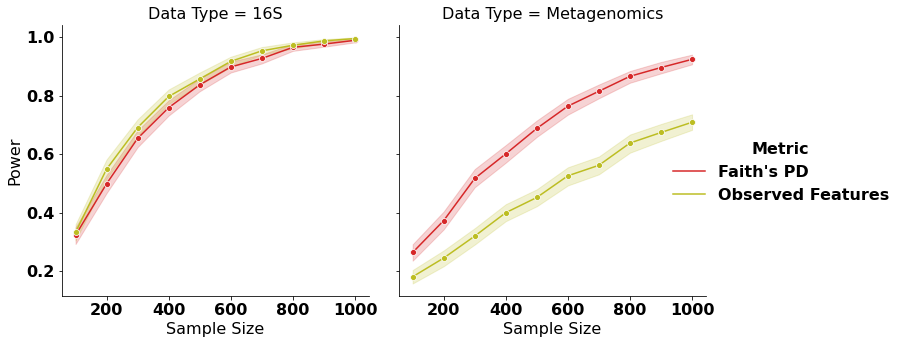

In [29]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

name_map = {
    'reject_null': 'Power',
    'data_type': 'Data Type'
}
sns.set_palette([sns.color_palette('tab10')[3], sns.color_palette('tab10')[8]])

power_df = power_df.replace({'shotgun': 'Metagenomics'})
power_df_renamed = power_df.rename(name_map, axis=1)


g = sns.relplot(
    x='sample_size',
    y=name_map['reject_null'],
    hue='metric',
    col=name_map['data_type'],
    kind='line',
    marker='o',
    data=power_df_renamed,
)

leg = g._legend
leg.set_title('Metric')
new_labels = ['Faith\'s PD', 'Observed Features']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

for ax in g.axes.flat:
    ax.set_xlabel('Sample Size')

plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('results/2.01-figure-02.png', dpi=400)